# Comparing a USGSCSM and ISIS camera for Kaguya Terrain Camera

In [1]:
import pvl
import os
import tempfile
import csmapi
import json

os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"

import knoten
import ale
from knoten import vis
from ale.drivers.selene_drivers import KaguyaTcPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm
from ale import util
from IPython.display import Image
from pysis import isis
from pysis.exceptions import ProcessError

import plotly
plotly.offline.init_notebook_mode(connected=True)

/home/kberry/anaconda3/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning: ALESPICEROOT environment variable not set, Spice Drivers will not function correctly
  warnings.warn('ALESPICEROOT environment variable not set, Spice Drivers will not function correctly')


## Make a CSM sensor model
Requires TC1S2B0_01_02842S506E1942.img in data directory

In [2]:
fileName = 'data/TC1S2B0_01_02842S506E1942.img'
camera = knoten.csm.create_csm(fileName)

## Ingest the image and spiceinit

In [3]:
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.kaguyatc2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)    
    
try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)
    
kernels = util.generate_kernels_from_cube(cub_loc, expand=True)

usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter='usgscsm', verbose=False)

csm_isd = os.path.splitext(fileName)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)    

## Compare USGS CSM and ISIS pixels

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

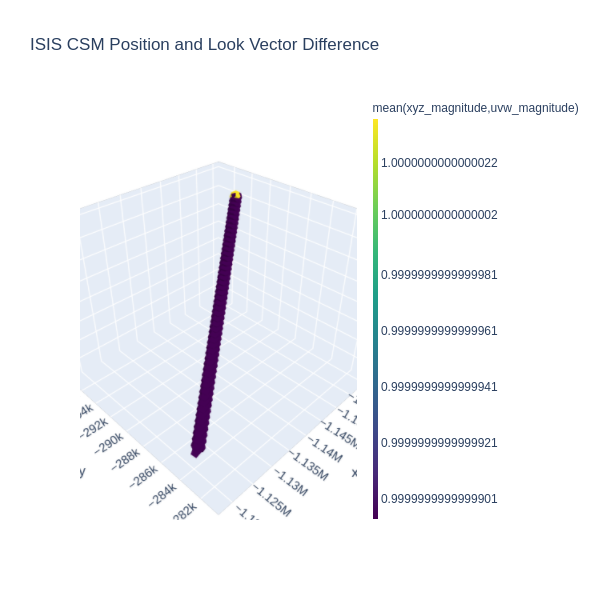

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

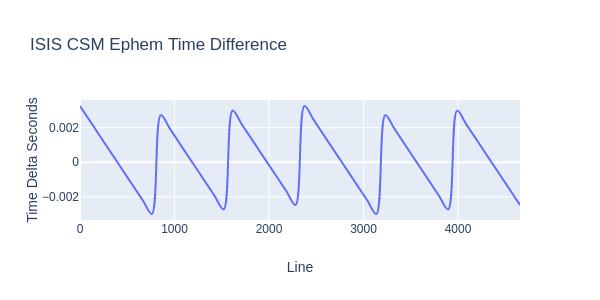

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,5.000000e+02,500.000000,5.000000e+02
mean,0.154286,0.043126,-0.142103,-1.302586e-05,-0.000054,3.781563e-05
std,2.262173,0.630010,2.007356,1.463740e-05,0.000004,2.144310e-05
min,-3.620074,-1.007640,-3.527532,-4.025997e-05,-0.000061,-6.529647e-08
25%,-1.729977,-0.481575,-1.832533,-2.559283e-05,-0.000057,1.918024e-05
50%,0.155818,0.043495,-0.139789,-1.293932e-05,-0.000054,3.805278e-05
75%,2.039954,0.568038,1.546390,-4.811364e-07,-0.000050,5.643052e-05
max,3.919830,1.091604,3.229557,1.396758e-05,-0.000046,7.570716e-05


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

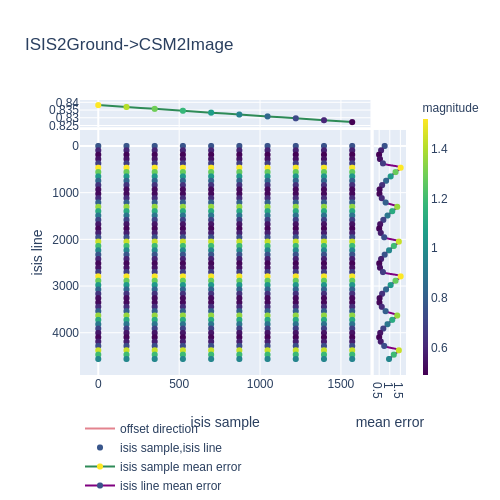

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.398894,0.499372
std,0.617954,0.007757
min,-1.427853,0.477568
25%,-0.913773,0.495300
50%,-0.399037,0.499671
75%,0.114991,0.503140
max,0.629142,0.521774


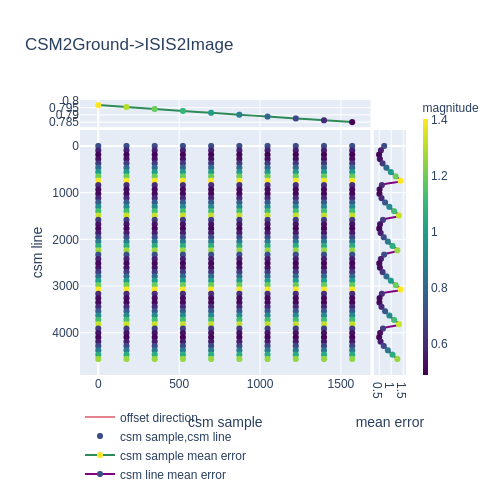

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.401019,-0.499345
std,0.542035,0.007486
min,-0.501736,-0.519836
25%,-0.049612,-0.503399
50%,0.400866,-0.499457
75%,0.851820,-0.495002
max,1.301956,-0.479078


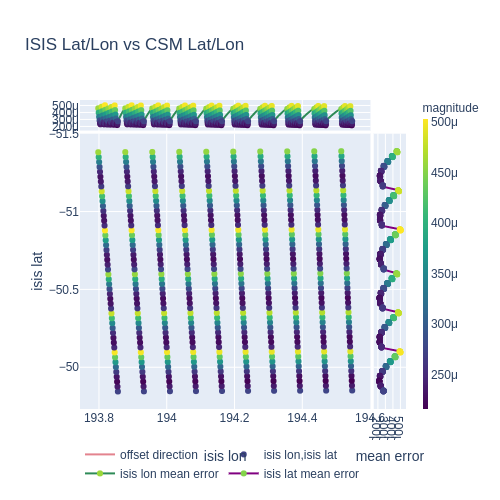

In [13]:
Image(isiscsm_plotlatlon.to_image())

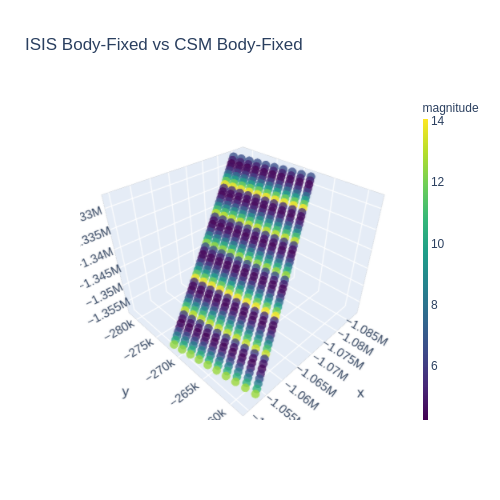

In [14]:
Image(isiscsm_plotbf.to_image())

In [15]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,-0.288653,5.015653,-2.552363
std,0.531779,1.151265,3.509908
min,-0.899663,3.107819,-8.482747
25%,-0.750005,4.006570,-5.532472
50%,-0.474012,5.012132,-2.570986
75%,0.090147,6.007950,0.365103
max,0.821095,7.103518,3.343934
